In [1]:
import itertools
from matplotlib import pyplot as plt
import pandas as pd
import torch
from torch.nn import Module, Linear
import torch.nn.functional as F
from torch.optim import SGD
from torch import special
from tqdm import tqdm

In [2]:
INPUT = torch.randint(2, size=(1000, 5), dtype=torch.float32)

most_likely_output = torch.concatenate((INPUT, INPUT), dim=1)
noise = torch.rand(most_likely_output.shape)
OUTPUT = most_likely_output.logical_xor(noise < 0.1).to(torch.float32)

INPUT_MARGINAL = torch.tensor([0.5] * 5)
OUTPUT_MARGINAL = torch.rand(10)

In [3]:
print(INPUT)
print(OUTPUT)
print(OUTPUT_MARGINAL)

tensor([[0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 1.]])
tensor([[0., 0., 1.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])
tensor([0.7580, 0.4738, 0.6755, 0.4689, 0.0932, 0.3981, 0.2668, 0.3859, 0.4292,
        0.1544])


In [4]:
ALL_POSSIBLE_INPUTS = [torch.tensor(x, dtype=torch.float32) for x in itertools.product([0, 1], repeat=5)]

In [5]:
class Dumpy(Module):
    def __init__(self, in_features: int, out_features: int):
        super(Dumpy, self).__init__()
        self.linear = Linear(in_features=in_features, out_features=out_features, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return special.expit(x)

    def forward_logit(self, x):
        return self.linear(x)

In [6]:
def train(lmb, epochs=5000):
    model = Dumpy(5, 10)
    optimizer = SGD(model.parameters(), lr=1)

    for _ in tqdm(range(epochs)):
        optimizer.zero_grad()

        model_output = model.forward_logit(INPUT)
        model_marginal = torch.mean(torch.stack([model.forward(input.unsqueeze(0)) for input in ALL_POSSIBLE_INPUTS], dim=0), dim=0)
        conditional_loss = F.binary_cross_entropy_with_logits(model_output, OUTPUT)
        marginal_loss = F.binary_cross_entropy(model_marginal, OUTPUT_MARGINAL.unsqueeze(0))
        loss = conditional_loss + lmb * marginal_loss

        loss.backward()
        optimizer.step()

    return conditional_loss.item(), marginal_loss.item()

In [7]:
lmbs = torch.logspace(-2, 2, 5)
results = {lmb.item(): train(lmb) for lmb in lmbs}

100%|██████████| 5000/5000 [00:03<00:00, 1266.24it/s]


In [8]:
results_table = pd.DataFrame(results)

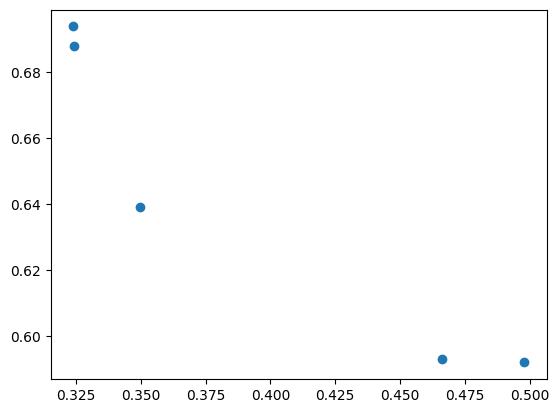

In [9]:
plt.figure()
plt.scatter(results_table.iloc[0], results_table.iloc[1])
# plt.xscale('log')
# plt.yscale('log')
plt.show()